In [ ]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression


In [ ]:
#File i/o

filename = "0228 Puncture Raw data for Jennifer" #@param {type:"string"}


df = pd.read_csv(f"{filename}.csv", on_bad_lines='skip',low_memory=False)
cols = df.shape[1] #pulling the total number of columns

data = {'Name': [], 'Force': [], 'Distance': [], 'Time': [], 'R_outer': [], 'DistanceSquared': [] }
data['R_outer'].append(df.iloc[2].to_numpy()) #collecting the needle diameter values in a list

for i in range(0, cols, 3):
  data['Name'].append(df.columns[i])
  #building force data list
  df2 = df.iloc[3:, i].to_numpy()
  force = []
  for item in df2:
    try:
      force.append(float(item))
    except:
      pass
  #building distance data list
  df3 = df.iloc[3:, i+1].to_numpy()
  distance = []
  for item in df3:
    try:
      distance.append(float(item))
    except:
      pass
  #building time data list
  df4 = df.iloc[3:, i+2].to_numpy()
  time = []
  for item in df4:
    try:
      time.append(float(item))
    except:
      pass
  #Building distance squared data list
  ds = []
  for item in distance:
    ds.append(item ** 2)

  #creating master lists for each category
  data['Force'].append(force)
  data['Distance'].append(distance)
  data['Time'].append(time)
  data['DistanceSquared'].append(ds)
  #data['R_outer'].append(df.iloc[2].to_numpy()) #collecting the needle diameter values in a list

print(len(data['Time']))

10


Run Main Function

In [ ]:
#Data Assembly
#@title  { run: "auto", vertical-output: true }
def data_assembly(sample_number, force, distance, time, names, smoothing_parameter, peak_prominence):
  max_datasets = len(names)
  #sample_number = 2 # @param {type:"slider", min:0, max:30, step:1}
  dataset = int(sample_number - 1) # Makes it so the user can start indexing at 1 instead of 0
  time = time[dataset]


  # Fixing the x not equal to y error --------------------------------------------
  # Truncating both arrays until they have the same size
  a = len(distance[dataset])
  b=len(force[dataset])

  if a == b:
    pass
  elif b > a:
    while b > a:
      force[dataset].pop()
      b=len(force[dataset])
  elif a > b:
    while a > b:
      distance[dataset].pop()
      a = len(distance[dataset])

  a = len(distance[dataset])
  b=len(force[dataset])



  #Switching Signs for Tension Test and Creating Distance Squared Values ---------
  testing_mode = "Tension"
  dc, dcs = [], []
  for item in distance[dataset]:
    dc.append(abs(item))
    dcs.append(abs(item) ** 2)
  y = force[dataset]
  x = dc




  # Smoothing the Data -----------------------------------------------------------

  #smoothing_parameter = 3 #@param {type:"slider", min:0, max:10, step:1}
  y_filter = savgol_filter(y, window_length=50, polyorder = smoothing_parameter, deriv=0) #Smooths our force data, and only the force data so we can more easily see where the contact begins
  x_filter = np.array(x) #converting list to array for math purposes
  time_filter = np.array(time)
  x_filter = x_filter[~np.isnan(y_filter)] #filtering x so it matches the new length of y for plotting
  time_filter = time_filter[~np.isnan(y_filter)]
  y_filter = y_filter[~np.isnan(y_filter)] #filtering out all the NaN values in the smoothed force data
  y_filter_list = y_filter.tolist()



  # Finding the Distance and Raw Contact Index at Probe Contact ------------------

  def detect_start_of_increase(data, min_points, confidence):
      """
      Detects the start of consistent increase in data using linear regression.

      Parameters:
          data (array-like): The input data array.
          min_points (int): The minimum number of data points to fit a regression line.
          confidence (float): The confidence level for determining significance.

      Returns:
          int: Index where consistent increase starts, or -1 if not found.
      """
      # Ensure we have enough data points for regression
      if len(data) < min_points:
          return -1

      # Fit linear regression to the data
      X = np.arange(len(data)).reshape(-1, 1)
      model = LinearRegression().fit(X, data)

      # Check if the slope of the regression line is significantly positive
      if model.coef_[0] > 0 and model.score(X, data) >= confidence:
          return 0  # Consistent increase starts from the beginning

      # Search for the point where the slope becomes significantly positive
      for i in range(1, len(data) - min_points + 1):
          X_sub = X[i:i+min_points]
          data_sub = data[i:i+min_points]
          model_sub = LinearRegression().fit(X_sub, data_sub)
          if model_sub.coef_[0] > 0 and model_sub.score(X_sub, data_sub) >= confidence:
              return i

      return -1  # No consistent increase detected

  max_index = y_filter_list.index(max(y_filter_list))
  start_index = detect_start_of_increase(y_filter_list[0:max_index], min_points=50, confidence=0.98)
  if start_index == -1:
      print("No consistent increase detected.")


  contact_force = y_filter_list[start_index]
  contact_distance = x_filter[start_index]



  #Automating the Peak Picking Process -------------------------------------------
  def peak_picking(data, height=None, threshold=None, prominence=None, distance=None, width=None):
      peaks, _ = find_peaks(data, height=height, threshold=threshold, prominence=prominence, distance=distance, width=width)
      return peaks

  truncated_force_filter = y_filter_list[cf_raw_index:]
  truncated_force_raw = y[cf_raw_index:]
  shift = len(y_filter_list) - len(truncated_force_filter)
  #peak_prominence = 0.05 #@param {type:"slider", min:0, max:3, step:0.05}
  peaks = peak_picking(truncated_force_filter, height=0, threshold=None, prominence=peak_prominence, distance=None, width=None)
  peaks = [int(n+shift) for n in peaks] #converting the indices to a list of integers
  xi = [x_filter[i] for i in peaks] #Isolating the distance values at the peak indices
  yi = [y_filter_list[j] for j in peaks] #Isolating the force values at the peak indices

  peak_number = 1
  peak_index = peak_number - 1
  fc = yi[peak_index]
  punc_dis = xi[peak_index]



  # Finding Turnaround Distance d0 -----------------------------------------------

  def find_shear_distance(dis_data, force_data, start_index, end_index):
    for g in range(start_index, end_index):
        if force_data[g] < 0:
            d0 = dis_data[g]
            d0_index = g
            return [d0, d0_index]

  fc_index = y_filter_list.index(fc)
  end_index = len(y_filter_list)
  d0_results = find_shear_distance(x_filter, y_filter, fc_index, end_index)
  d0 = d0_results[0]
  #d0_data.append(d0)
  d0_index = d0_results[1]



  # Finding boundaries for indentaiton regimes -----------------------------------

  ## Region 1
  region1_start = 0
  region1_end = fc_index
  region1_fd = y_filter_list[region1_start:region1_end]
  region1_dd = x_filter[region1_start:region1_end]

  ## Region II
  region2_start = fc_index
  if len(yi)>2:
    region2_end = y_filter_list.index(yi[1]) #ending at the second "peak"
  else:
    region2_end = y_filter_list.index(max(y_filter_list))
  region2_fd = y_filter_list[region2_start:region2_end]
  region2_dd = x_filter[region2_start:region2_end]

  ## Region IV
  region4_start_force = min(y_filter_list)
  region4_start = y_filter_list.index(region4_start_force)
  region4_end = len(y_filter_list) - 1
  region4_fd = y_filter_list[region4_start:region4_end]
  region4_dd = x_filter[region4_start:region4_end]

  ## Region III
  region3_start = region2_end
  region3_end = region4_start
  region3_fd = y_filter_list[region3_start:region3_end]
  region3_dd = x_filter[region3_start:region3_end]



  # Plotting Everything ----------------------------------------------------------

  ## ------------- Force v Distance --------------


  ### Lines

  plt.plot(dc, force[dataset],'o', color='lightgrey', markersize=7)
  #plt.plot(x_filter,y_filter,color='mediumblue')
  plt.plot(region1_dd, region1_fd, color = 'lightcoral', linewidth='2', label='Region I')
  plt.plot(region2_dd, region2_fd, color = 'firebrick', linewidth='2', label='Region II')
  plt.plot(region3_dd, region3_fd, color = 'cornflowerblue', linewidth='2', label='Region III')
  plt.plot(region4_dd, region4_fd, color = 'mediumblue', linewidth='2', label='Region IV')

  ### Points
  plt.plot(contact_distance, contact_force, 'o', color='darkred', markersize=8, label='Contact Point')
  plt.plot(punc_dis,yi[peak_index],'s', color='darkred', markersize=8, label='Puncture Force/Distance')
  plt.plot(d0, y_filter[d0_index],'^', color='midnightblue', markersize=10, label='Shearing Distance')


  ### Graph Details
  font_size = 13
  distance_min = 0-0.1
  distance_max = max(dc)+0.1
  plt.xlim([distance_min,distance_max])
  plt.xlabel("Distance (mm)", fontsize=font_size, weight='bold')
  plt.ylabel("Force (mN)", fontsize=font_size, weight='bold')
  plt.title(names[dataset], fontsize=font_size, weight='bold')
  plt.xticks(fontsize = font_size)
  plt.legend()



  ## ----------- Force v Time ---------------

  ### Lines
  plt.plot(time, force[dataset],'o', color='lightblue', markersize=7, label='Raw Data')
  plt.plot(time_filter,y_filter, color='mediumblue', linewidth='2', label='Smoothed Data')

  ### Graph Details
  plt.xlim([-0.1, max(time)+0.1])
  plt.xlabel("Time (s)")
  plt.ylabel("Force (mN)")
  plt.title(names[dataset])
  plt.legend()



  # Calculations -----------------------------------------------------------------

  ## -------- k'E linear regression ------------
  x_filter_list = x_filter.tolist()
  lower = start_index
  lb = x_filter_list[start_index]
  ssl_cd = round(contact_distance + 0.1,3) #assumes small strain limit is 0.1mm
  upper = x_filter_list.index(ssl_cd)
  ub = x_filter_list[upper]

  x_filter_sqrd = []
  for q in range(len(x_filter_list)):
    squared = (x_filter_list[q])**2
    x_filter_sqrd.append(squared)

  lrx, lry = [], []
  for i in range(lower, upper):
    lrx.append(x_filter_sqrd[i])
    lry.append(y_filter_list[i])
  lrx = np.array(lrx).reshape(-1, 1)
  lry = np.array(lry)

  model = LinearRegression().fit(lrx, lry)

  ## -------- Embedding Linear Regression ------------
  lrxe = x_filter_list[region2_start:region2_end]
  Xe = [[val] for val in lrxe]
  lrye = y_filter_list[region2_start:region2_end]
  lin_fit_e = LinearRegression().fit(Xe, lrye)
  me = float(lin_fit_e.coef_)
  rs_e= lin_fit_e.score(Xe,lrye)

  ## -------- Shearing Linear Regression ------------
  lrxs = x_filter_list[region3_start:region3_end]
  Xs = [[val] for val in lrxs]
  lrys = y_filter_list[region3_start:region3_end]
  lin_fit_s = LinearRegression().fit(Xs, lrys)
  ms = float(lin_fit_s.coef_)
  rs_s= lin_fit_s.score(Xs,lrys)

  ## -------- Pullout Linear Regression ------------
  lrxp = x_filter_list[region4_start:region4_end]
  Xp = [[val] for val in lrxp]
  lryp = y_filter_list[region4_start:region4_end]
  lin_fit_p = LinearRegression().fit(Xp, lryp)
  mp = float(lin_fit_p.coef_)
  rs_p= lin_fit_p.score(Xp,lryp)

  ## -------- Calculating Relevant Parameters ---------

  fc = yi[0] # [mN] puncture force

  d = xi[0] # [mm] distance at puncture

  kprimeE = float(model.coef_)
  rs_kprime = model.score(lrx,lry)

#  print(f"Critical Load at Puncture (mN): {round(fc,3)}")
#  print(f"Critical Distance at Puncture (mm): {round(d,3)}")
#  print(f"Shear Loading Distance (mm): {round(d0,3)}")

#  print(f"k'E Value: {round(kprimeE,3)}")
#  print(f"k'E R_Squared: {round(model.score(lrx,lry),3)}")

#  print(f"Embedding Slope: {round(me,3)}")
#  print(f"me R_Squared: {round(rs_e,3)}")

#  print(f"Shearing Slope Slope: {round(ms,3)}")
#  print(f"ms R_Squared: {round(rs_s,3)}")

#  print(f"Pullout Slope: {round(mp,3)}")
#  print(f"mp R_Squared: {round(rs_p,3)}")

  return [fc, d, d0, kprimeE, rs_kprime, me, rs_e, ms, rs_s, mp, rs_p]


<ipython-input-222-812e8588e84e>:251: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  me = float(lin_fit_e.coef_)
<ipython-input-222-812e8588e84e>:259: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ms = float(lin_fit_s.coef_)
<ipython-input-222-812e8588e84e>:267: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mp = float(lin_fit_p.coef_)
<ipython-input-222-812e8588e84e>:276: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will er

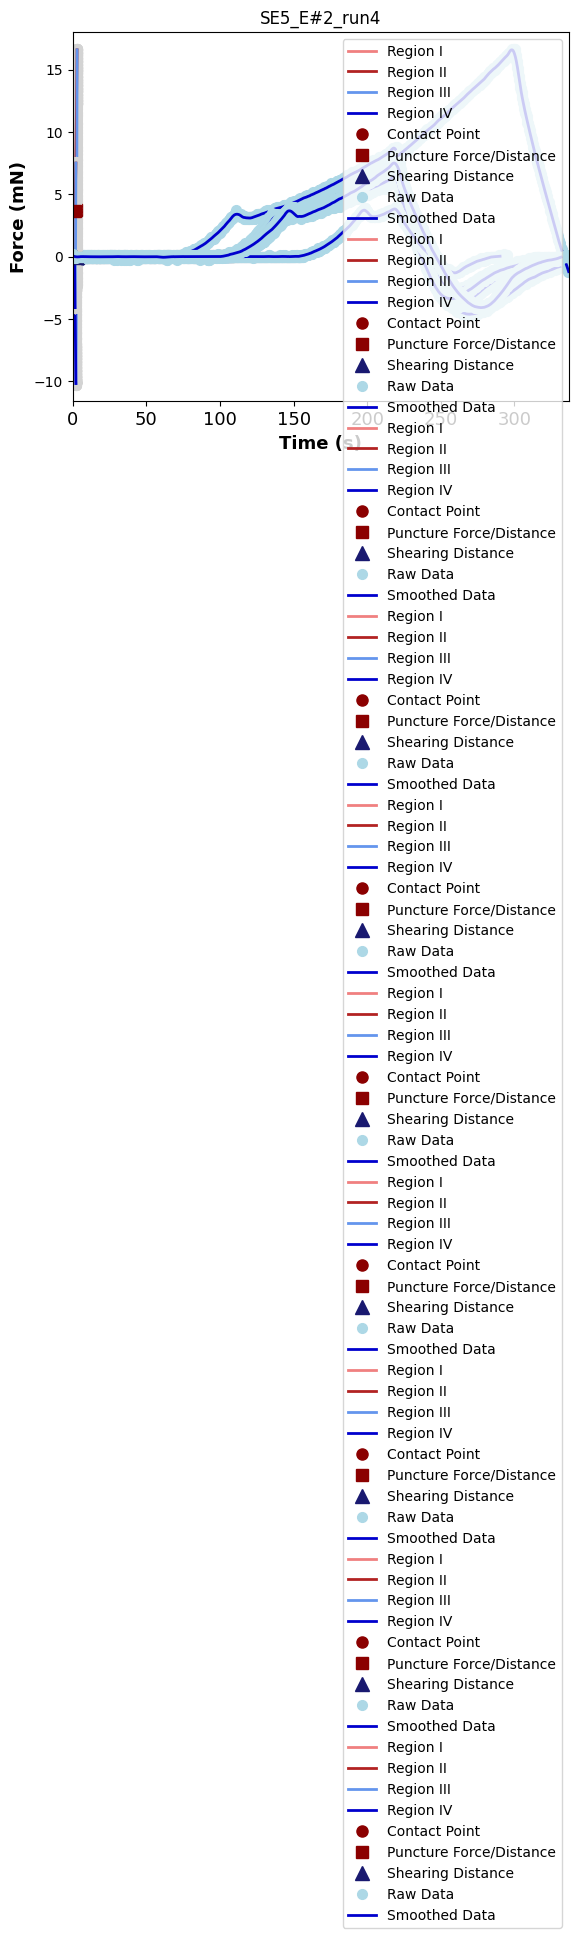

In [ ]:
sample_number = 2 # @param {type:"slider", min:0, max:30, step:1}
smoothing_parameter = 3 #@param {type:"slider", min:0, max:10, step:1}
peak_prominence = 0.05 #@param {type:"slider", min:0, max:3, step:0.05}

force = data['Force']
distance = data['Distance']
time = data['Time']
names = data['Name']

for n in range(len(names)):
  parameters = data_assembly(n+1, force, distance, time, names, smoothing_parameter, peak_prominence)
# [fc, d, d0, kprimeE, rs_kprime, me, rs_e, ms, rs_s, mp, rs_p]




In [ ]:
df = pd.DataFrame({'Sample Name': samplename_data, 'Puncture Force': fc_data, 'Distance at Puncture': d_data, 'kE': kprimeE_data})
print(df)

#writer = pd.ExcelWriter('indenttest.xlsx')
#df.to_excel(writer, sheet_name='welcome', index=False)
#writer.save()

                           Sample Name  Puncture Force  Distance at Puncture  \
0  0.5 gL TEMPO_NP_600ueqg_CaCl2_no1_1        1.625980                 4.822   
1  0.5 gL TEMPO_NP_600ueqg_CaCl2_no2_1        1.357604                 2.822   
2  0.5 gL TEMPO_NP_600ueqg_CaCl2_no3_1        1.757751                 2.482   
3  0.7 gL TEMPO_NP_600ueqg_CaCl2_no1_2        1.356395                 2.769   
4  0.7 gL TEMPO_NP_600ueqg_CaCl2_no2_1        9.441559                 6.869   
5  0.7 gL TEMPO_NP_600ueqg_CaCl2_no3_1        2.641460                 4.274   
6  0.9 gL TEMPO_NP_600ueqg_CaCl2_no1_1       11.451976                 6.002   
7  0.9 gL TEMPO_NP_600ueqg_CaCl2_no2_1        7.816791                 5.052   

   Fracture Gc                     kE  
0     4.782296    [0.259329417171805]  
1     3.992954        [1.75611817916]  
2     5.169855    [4.514128701860809]  
3     3.989399   [1.0722874028979035]  
4    27.769291   [0.9658806105986201]  
5     7.769000  [-0.5404956511640227]  